# MADI Anomaly Detection — IoT Sensor Data

Step through each stage: data loading, negative sampling, detector training, and ROC curve evaluation.

> **Run from the project root** (`sensoriot_project/`) so that relative paths resolve correctly.

In [3]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tqdm.notebook import tqdm

# Allow imports from ad/ when running from the project root
sys.path.insert(0, os.path.join(os.getcwd(), 'ad'))

from madi.detectors.isolation_forest_detector import IsolationForestAd
from madi.detectors.one_class_svm import OneClassSVMAd
from madi.detectors.neg_sample_random_forest import NegativeSamplingRandomForestAd
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
import madi.utils.sample_utils as sample_utils
import madi.utils.evaluation_utils as evaluation_utils

DATA_PATH = 'data/gdtechdb_prod.Sensors.csv'
OUTPUT_DIR = 'output'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'logs'), exist_ok=True)
print('Setup complete.')

Setup complete.


In [18]:
def epoch_to_human(ts, tz='UTC'):
    """Convert Unix epoch timestamp(s) to human-readable datetime string(s).

    Args:
        ts: scalar int/float, or a pandas Series/list/array of epoch timestamps.
        tz: IANA timezone name (default 'UTC'). E.g. 'US/Eastern', 'America/Chicago'.

    Returns:
        str for scalar inputs; pandas Series[str] for array inputs.

    Examples:
        epoch_to_human(1769012592)
        # -> '2026-01-17 01:23:12 UTC'

        epoch_to_human(df['time_rounded'], tz='US/Eastern')
    """
    scalar = not isinstance(ts, (pd.Series, list, np.ndarray))
    series = pd.to_datetime(pd.Series([ts] if scalar else ts), unit='s', utc=True)
    series = series.dt.tz_convert(tz).dt.strftime('%Y-%m-%d %H:%M:%S %Z')
    return series.iloc[0] if scalar else series.reset_index(drop=True)


# Quick demo — first and last timestamps across all nodes
for node_id, df in sorted(node_dfs.items()):
    if 'time_rounded' in df.columns:
        t_start = epoch_to_human(df['time_rounded'].min())
        t_end   = epoch_to_human(df['time_rounded'].max())
        print(f'Node {node_id:>4}: {t_start}  →  {t_end}')

Node    1: 2026-01-21 16:23:13 UTC  →  2026-02-28 03:46:30 UTC
Node   88: 2026-01-21 16:27:39 UTC  →  2026-02-28 03:47:17 UTC
Node  102: 2026-02-15 20:56:19 UTC  →  2026-02-28 03:39:20 UTC
Node  106: 2026-01-21 16:30:48 UTC  →  2026-02-28 03:45:00 UTC
Node  108: 2026-01-21 16:32:47 UTC  →  2026-02-28 03:28:20 UTC


## 1. Load & Pivot Data

Read the long-format CSV, strip the `b'...'` byte-string wrapper from values,
round timestamps to the nearest second to pair each node’s F and H readings
(sent within ~35 ms of each other), then pivot to a wide `(F, H)` DataFrame per node.

In [26]:
def load_and_pivot(csv_path):
    df = pd.read_csv(csv_path)
    # Strip byte-string wrapper: b'71.08' -> 71.08
    df['value'] = (df['value'].astype(str)
                   .str.replace("b'", '', regex=False)
                   .str.replace("'", '', regex=False))
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df = df.dropna(subset=['value'])
    df['time_rounded'] = df['time'].round().astype(int)
    node_dfs = {}
    for node_id, group in df.groupby('node_id'):
        pivoted = group.pivot_table(
            index='time_rounded', columns='type', values='value', aggfunc='first'
        )
        if 'F' not in pivoted.columns or 'H' not in pivoted.columns:
            continue
        pivoted = pivoted[['F', 'H','P']].dropna().reset_index(drop=False)
        node_dfs[node_id] = pivoted
    return node_dfs

node_dfs = load_and_pivot(DATA_PATH)

summary = pd.DataFrame([
    {
        'node_id': node_id,
        'samples': len(df),
        'F_min': round(df['F'].min(), 2),
        'F_max': round(df['F'].max(), 2),
        'H_min': round(df['H'].min(), 2),
        'H_max': round(df['H'].max(), 2),
        'P_min': round(df['P'].min(), 2),
        'P_max': round(df['P'].max(), 2),
        'time_min' : epoch_to_human(round(df['time_rounded'].min(), 0)),
        'time_max' : epoch_to_human(round(df['time_rounded'].max(), 0)),
        
    }
    for node_id, df in sorted(node_dfs.items())
])
summary

,node_id,samples,F_min,F_max,H_min,H_max,P_min,P_max,time_min,time_max
0,1,5157,57.94,73.13,26.21,45.44,29.27,30.42,2026-01-21 16:23:13 UTC,2026-02-28 15:06:30 UTC
1,88,4128,28.98,67.01,28.38,47.08,29.27,30.53,2026-01-21 16:27:39 UTC,2026-02-28 15:22:04 UTC
2,102,1408,66.81,72.18,27.83,47.06,29.30,29.97,2026-02-15 20:56:19 UTC,2026-02-28 15:27:38 UTC
3,106,4024,67.62,72.81,30.57,39.41,29.27,30.42,2026-01-21 16:30:48 UTC,2026-02-28 15:20:18 UTC
4,108,4109,3.09,46.74,44.94,80.87,29.25,30.39,2026-01-21 16:32:47 UTC,2026-02-28 15:19:27 UTC


## 2. Explore Raw Data

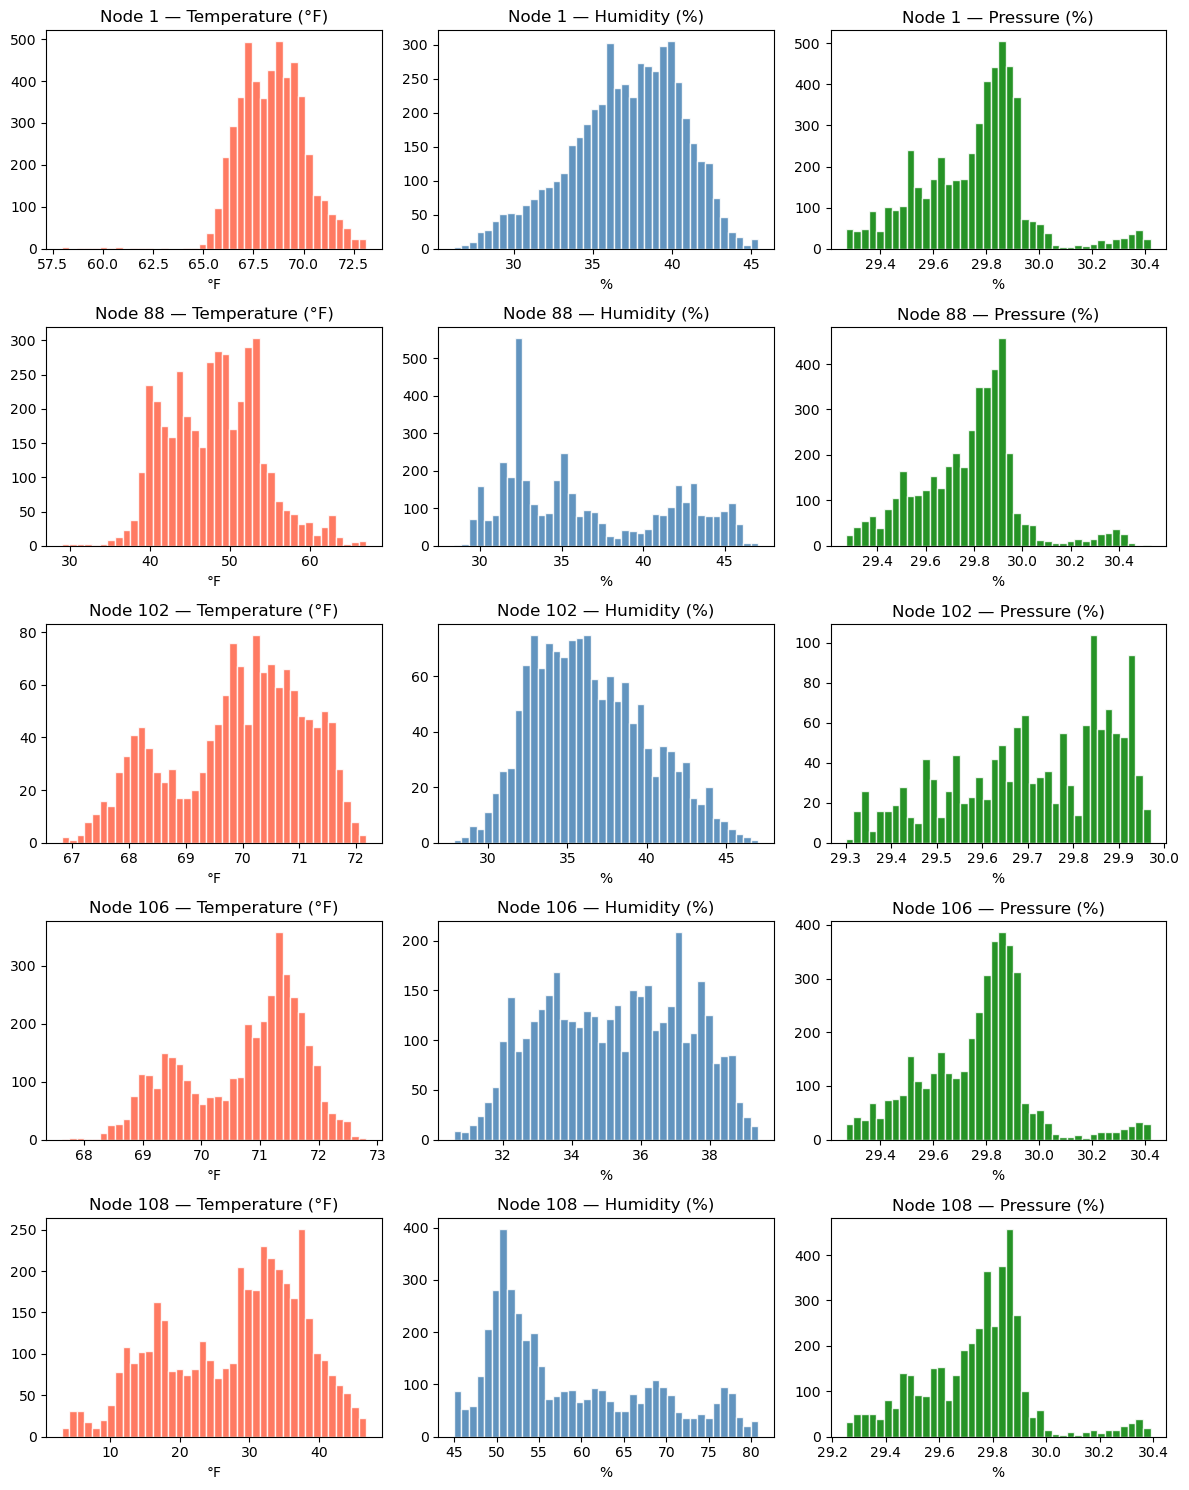

In [31]:
fig, axes = plt.subplots(len(node_dfs), 3, figsize=(12, 3 * len(node_dfs)))
if len(node_dfs) == 1:
    axes = [axes]
for i, (node_id, df) in enumerate(sorted(node_dfs.items())):
    axes[i][0].hist(df['F'], bins=40, color='tomato', edgecolor='white', alpha=0.85)
    axes[i][0].set_title(f'Node {node_id} — Temperature (°F)')
    axes[i][0].set_xlabel('°F')
    axes[i][1].hist(df['H'], bins=40, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i][1].set_title(f'Node {node_id} — Humidity (%)')
    axes[i][1].set_xlabel('%')
    axes[i][2].hist(df['P'], bins=40, color='green', edgecolor='white', alpha=0.85)
    axes[i][2].set_title(f'Node {node_id} — Pressure (%)')
    axes[i][2].set_xlabel('%')
plt
plt.tight_layout()
plt.show()

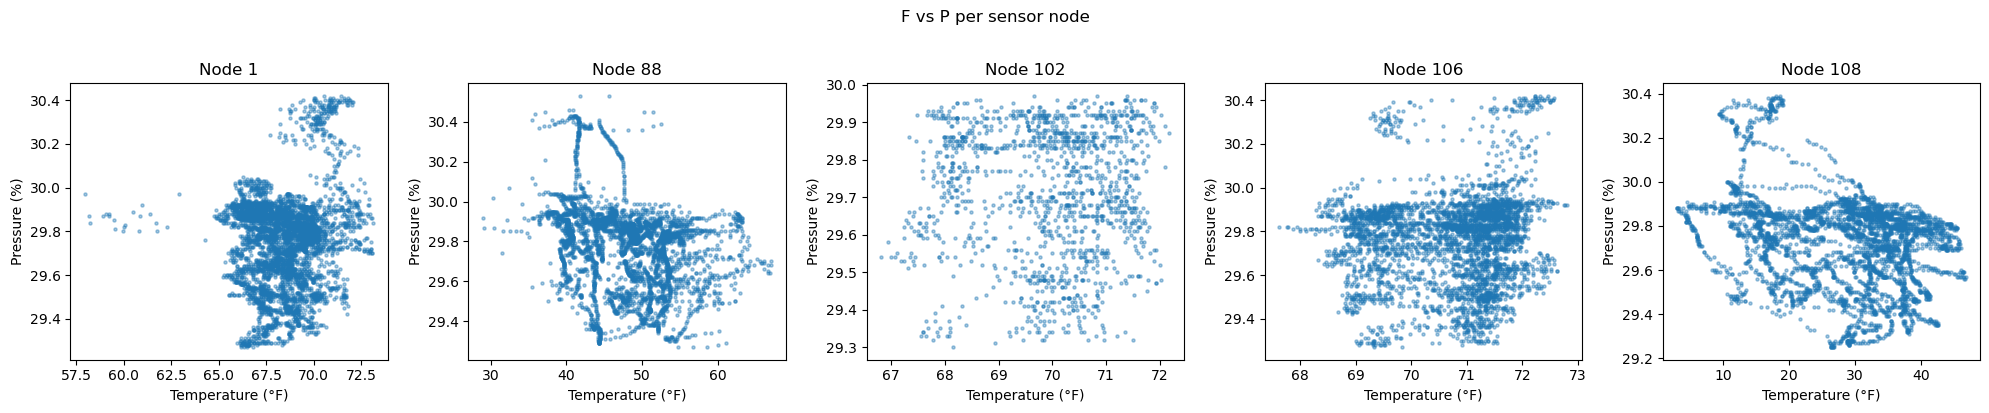

In [34]:
n_nodes = len(node_dfs)
fig, axes = plt.subplots(1, n_nodes, figsize=(4 * n_nodes, 4))
if n_nodes == 1:
    axes = [axes]
for ax, (node_id, df) in zip(axes, sorted(node_dfs.items())):
    ax.scatter(df['F'], df['P'], s=5, alpha=0.4)
    ax.set_xlabel('Temperature (°F)')
    ax.set_ylabel('Pressure (%)')
    ax.set_title(f'Node {node_id}')
plt.suptitle('F vs P per sensor node', y=1.02)
plt.tight_layout()
plt.show()

## 3. Generate Negative-Sampled Datasets

Negative sampling generates synthetic out-of-distribution points uniformly within
`[min − δ·range, max + δ·range]` for each feature dimension.
The combined dataset (real = 1, synthetic = 0) is saved as a CSV per node.

In [35]:
SAMPLE_RATIO = 2.0   # 2 synthetic points per real point
SAMPLE_DELTA = 0.05  # extend sampling bounds 5% beyond observed range

neg_sampled_dfs = {}
for node_id, df in tqdm(sorted(node_dfs.items()), desc='Nodes'):
    ns = sample_utils.apply_negative_sample(df.copy(), sample_ratio=SAMPLE_RATIO, sample_delta=SAMPLE_DELTA)
    neg_sampled_dfs[node_id] = ns
    path = os.path.join(OUTPUT_DIR, f'node_{node_id}_negative_sampled.csv')
    ns.to_csv(path, index=False)

for node_id, ns in sorted(neg_sampled_dfs.items()):
    pos = int((ns['class_label'] == 1).sum())
    neg = int((ns['class_label'] == 0).sum())
    print(f'Node {node_id:>4}: {pos:>5} real  +  {neg:>5} synthetic  =  {pos+neg} total')

Nodes:   0%|          | 0/5 [00:00<?, ?it/s]

Node    1:  5157 real  +  10314 synthetic  =  15471 total
Node   88:  4128 real  +   8256 synthetic  =  12384 total
Node  102:  1408 real  +   2816 synthetic  =  4224 total
Node  106:  4024 real  +   8048 synthetic  =  12072 total
Node  108:  4109 real  +   8218 synthetic  =  12327 total


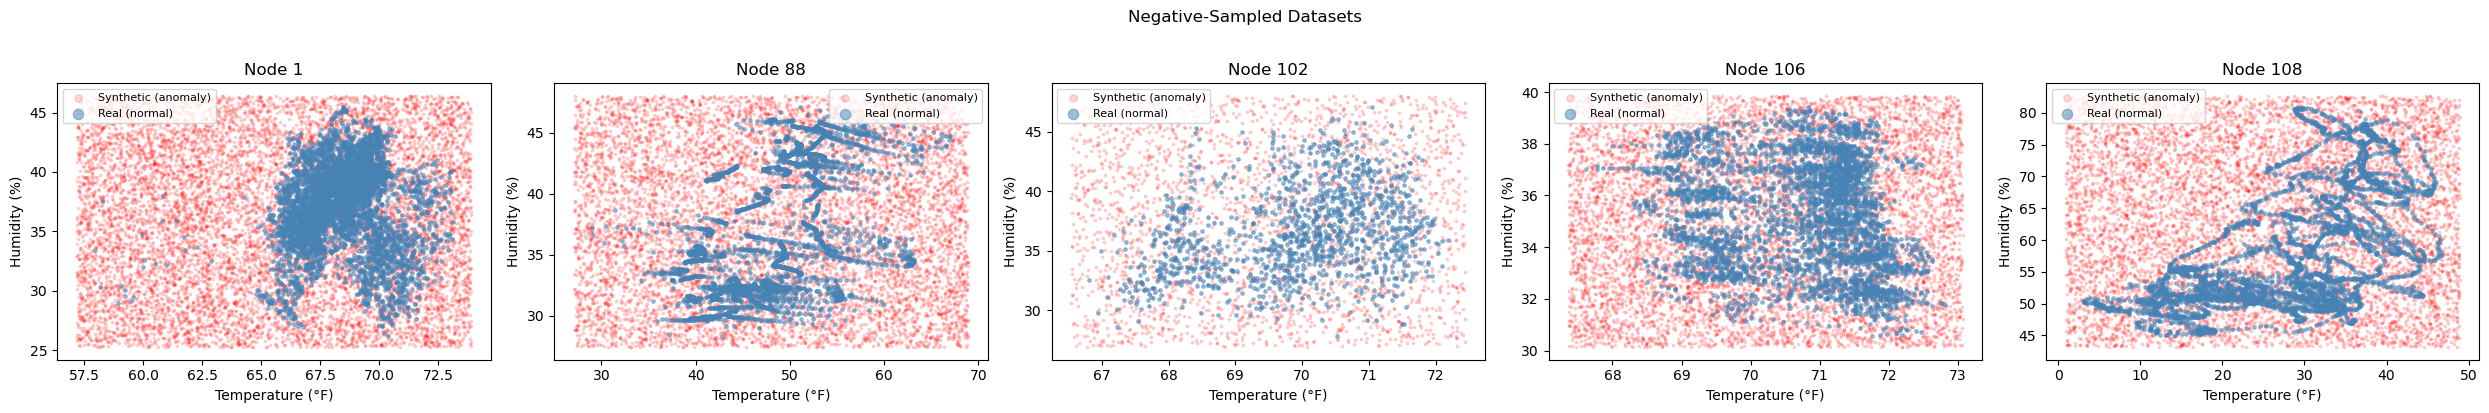

In [23]:
fig, axes = plt.subplots(1, n_nodes, figsize=(5 * n_nodes, 4))
if n_nodes == 1:
    axes = [axes]
for ax, (node_id, ns) in zip(axes, sorted(neg_sampled_dfs.items())):
    real  = ns[ns['class_label'] == 1]
    synth = ns[ns['class_label'] == 0]
    ax.scatter(synth['F'], synth['H'], s=3, alpha=0.15, color='red',       label='Synthetic (anomaly)')
    ax.scatter(real['F'],  real['H'],  s=6, alpha=0.50, color='steelblue', label='Real (normal)')
    ax.set_title(f'Node {node_id}')
    ax.set_xlabel('Temperature (°F)')
    ax.set_ylabel('Humidity (%)')
    ax.legend(markerscale=3, fontsize=8)
plt.suptitle('Negative-Sampled Datasets', y=1.02)
plt.tight_layout()
plt.show()

## 4. Train / Test Split

80 % training, 20 % held-out test. The test split is later augmented with synthetic
negatives (via `get_train_data`) to produce a labeled evaluation set.

In [36]:
train_dfs, test_dfs = {}, {}
for node_id, df in node_dfs.items():
    shuffled = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    n_train = int(0.8 * len(shuffled))
    train_dfs[node_id] = shuffled.iloc[:n_train].copy()
    test_dfs[node_id]  = shuffled.iloc[n_train:].copy()

pd.DataFrame([
    {'node_id': nid, 'train': len(train_dfs[nid]), 'test': len(test_dfs[nid])}
    for nid in sorted(train_dfs)
])

,node_id,train,test
0,1,4125,1032
1,88,3302,826
2,102,1126,282
3,106,3219,805
4,108,3287,822


## 5. Train Detectors

Four detector types are trained per node:

| Detector | Type | Negative sampling |
|---|---|---|
| `IsolationForest` | Unsupervised | No |
| `OneClassSVM` | Unsupervised | No |
| `NS-RandomForest` | Supervised (binary) | Yes — at train time |
| `NS-NeuralNet` | Supervised (binary) | Yes — per mini-batch |

The outer loops use `tqdm` progress bars. The neural network prints Keras epoch progress below its cell.

In [37]:
def make_detectors(node_id):
    return {
        'IsolationForest': IsolationForestAd(
            contamination=0.05, random_state=RANDOM_SEED
        ),
        'OneClassSVM': OneClassSVMAd(nu=0.1),
        'NS-RandomForest': NegativeSamplingRandomForestAd(
            n_estimators=100,
            sample_ratio=SAMPLE_RATIO,
            sample_delta=SAMPLE_DELTA,
            random_state=RANDOM_SEED,
        ),
        'NS-NeuralNet': NegativeSamplingNeuralNetworkAD(
            sample_ratio=SAMPLE_RATIO,
            sample_delta=SAMPLE_DELTA,
            batch_size=64,
            steps_per_epoch=10,
            epochs=50,
            patience=5,
            dropout=0.2,
            learning_rate=0.001,
            layer_width=64,
            n_hidden_layers=2,
            log_dir=os.path.join(OUTPUT_DIR, 'logs', f'node_{node_id}'),
        ),
    }

In [38]:
all_results = {}  # {node_id: {det_name: {'y_true', 'y_score', 'auc'} | None}}

for node_id in tqdm(sorted(node_dfs.keys()), desc='Nodes', position=0):
    x_train    = train_dfs[node_id]
    x_test_raw = test_dfs[node_id]

    # Build labeled test set: real positives + equal synthetic negatives
    test_ratio   = 1.0
    n_test_pts   = int(len(x_test_raw) * (1 + test_ratio))
    x_test, y_test = sample_utils.get_train_data(
        x_test_raw, n_points=n_test_pts, sample_ratio=test_ratio, do_permute=True
    )

    detectors    = make_detectors(node_id)
    node_results = {}

    for det_name, detector in tqdm(detectors.items(), desc=f'Node {node_id}', position=1, leave=False):
        try:
            detector.train_model(x_train.copy())
            result_df = detector.predict(x_test.copy())
            auc_val   = evaluation_utils.compute_auc(y_test.values, result_df['class_prob'].values)
            node_results[det_name] = {
                'y_true':  y_test.values,
                'y_score': result_df['class_prob'].values,
                'auc':     auc_val,
            }
            tqdm.write(f'  Node {node_id} | {det_name:<16s}: AUC = {auc_val:.4f}')
        except Exception as exc:
            tqdm.write(f'  Node {node_id} | {det_name:<16s}: FAILED — {exc}')
            node_results[det_name] = None

    all_results[node_id] = node_results

Nodes:   0%|          | 0/5 [00:00<?, ?it/s]

Node 1:   0%|          | 0/4 [00:00<?, ?it/s]

  Node 1 | IsolationForest : AUC = 0.5102
  Node 1 | OneClassSVM     : AUC = 0.6163
  Node 1 | NS-RandomForest : AUC = 0.9479
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.5776 - loss: 0.6640 - val_binary_accuracy: 0.6667 - val_loss: 0.5933
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6677 - loss: 0.5701 - val_binary_accuracy: 0.6667 - val_loss: 0.5166
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.6698 - loss: 0.5700 - val_binary_accuracy: 0.6667 - val_loss: 0.5465
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6880 - loss: 0.5453 - val_binary_accuracy: 0.6875 - val_loss: 0.5124
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7000 - loss: 0.5226 - val_binary_accuracy: 0.7188 - val_loss: 0.4943
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7182 - loss: 0.5034 - val_binary_accuracy: 0.7344 - val_loss: 0.4918
Epoch 7/50
10/10 ━━━━━━━━━━━━━━

Node 88:   0%|          | 0/4 [00:00<?, ?it/s]

  Node 88 | IsolationForest : AUC = 0.5297
  Node 88 | OneClassSVM     : AUC = 0.7070
  Node 88 | NS-RandomForest : AUC = 0.9818
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.6484 - loss: 0.6094 - val_binary_accuracy: 0.6667 - val_loss: 0.5808
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6708 - loss: 0.5613 - val_binary_accuracy: 0.6615 - val_loss: 0.5226
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.6964 - loss: 0.5342 - val_binary_accuracy: 0.7865 - val_loss: 0.4677
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7370 - loss: 0.5045 - val_binary_accuracy: 0.8333 - val_loss: 0.4610
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7828 - loss: 0.4720 - val_binary_accuracy: 0.8229 - val_loss: 0.4333
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7786 - loss: 0.4703 - val_binary_accuracy: 0.8125 - val_loss: 0.4325
Epoch 7/50
10/10 ━━━━━━━━━━━━

Node 102:   0%|          | 0/4 [00:00<?, ?it/s]

  Node 102 | IsolationForest : AUC = 0.5337
  Node 102 | OneClassSVM     : AUC = 0.5887
  Node 102 | NS-RandomForest : AUC = 0.9388
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.6297 - loss: 0.6351 - val_binary_accuracy: 0.6667 - val_loss: 0.5970
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6661 - loss: 0.6019 - val_binary_accuracy: 0.6667 - val_loss: 0.5839
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.6719 - loss: 0.5827 - val_binary_accuracy: 0.6719 - val_loss: 0.5826
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6750 - loss: 0.5749 - val_binary_accuracy: 0.6875 - val_loss: 0.5568
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6672 - loss: 0.5794 - val_binary_accuracy: 0.6562 - val_loss: 0.5670
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6776 - loss: 0.5705 - val_binary_accuracy: 0.7083 - val_loss: 0.5673
Epoch 7/50
10/10 ━━━━━━━━━

Node 106:   0%|          | 0/4 [00:00<?, ?it/s]

  Node 106 | IsolationForest : AUC = 0.5193
  Node 106 | OneClassSVM     : AUC = 0.6062
  Node 106 | NS-RandomForest : AUC = 0.9633
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.6682 - loss: 0.5924 - val_binary_accuracy: 0.6667 - val_loss: 0.6102
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6667 - loss: 0.5727 - val_binary_accuracy: 0.6667 - val_loss: 0.5498
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.6776 - loss: 0.5474 - val_binary_accuracy: 0.6719 - val_loss: 0.5010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.6849 - loss: 0.5413 - val_binary_accuracy: 0.7083 - val_loss: 0.5246
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7141 - loss: 0.5146 - val_binary_accuracy: 0.7083 - val_loss: 0.5147
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7255 - loss: 0.5188 - val_binary_accuracy: 0.6823 - val_loss: 0.5017
Epoch 7/50
10/10 ━━━━━━━━━

Node 108:   0%|          | 0/4 [00:00<?, ?it/s]

  Node 108 | IsolationForest : AUC = 0.5669
  Node 108 | OneClassSVM     : AUC = 0.7153
  Node 108 | NS-RandomForest : AUC = 0.9827
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.6557 - loss: 0.6088 - val_binary_accuracy: 0.6667 - val_loss: 0.5715
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.6667 - loss: 0.5550 - val_binary_accuracy: 0.6667 - val_loss: 0.5128
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.6760 - loss: 0.5181 - val_binary_accuracy: 0.7031 - val_loss: 0.4924
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7031 - loss: 0.4829 - val_binary_accuracy: 0.7396 - val_loss: 0.4600
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7500 - loss: 0.4638 - val_binary_accuracy: 0.7812 - val_loss: 0.4211
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7760 - loss: 0.4326 - val_binary_accuracy: 0.7865 - val_loss: 0.3968
Epoch 7/50
10/10 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Node 108 | NS-NeuralNet    : AUC = 0.8269


## 6. ROC Curves

One subplot per node; all four detectors overlaid. AUC shown in the legend.
The dashed diagonal represents a random classifier (AUC = 0.50).

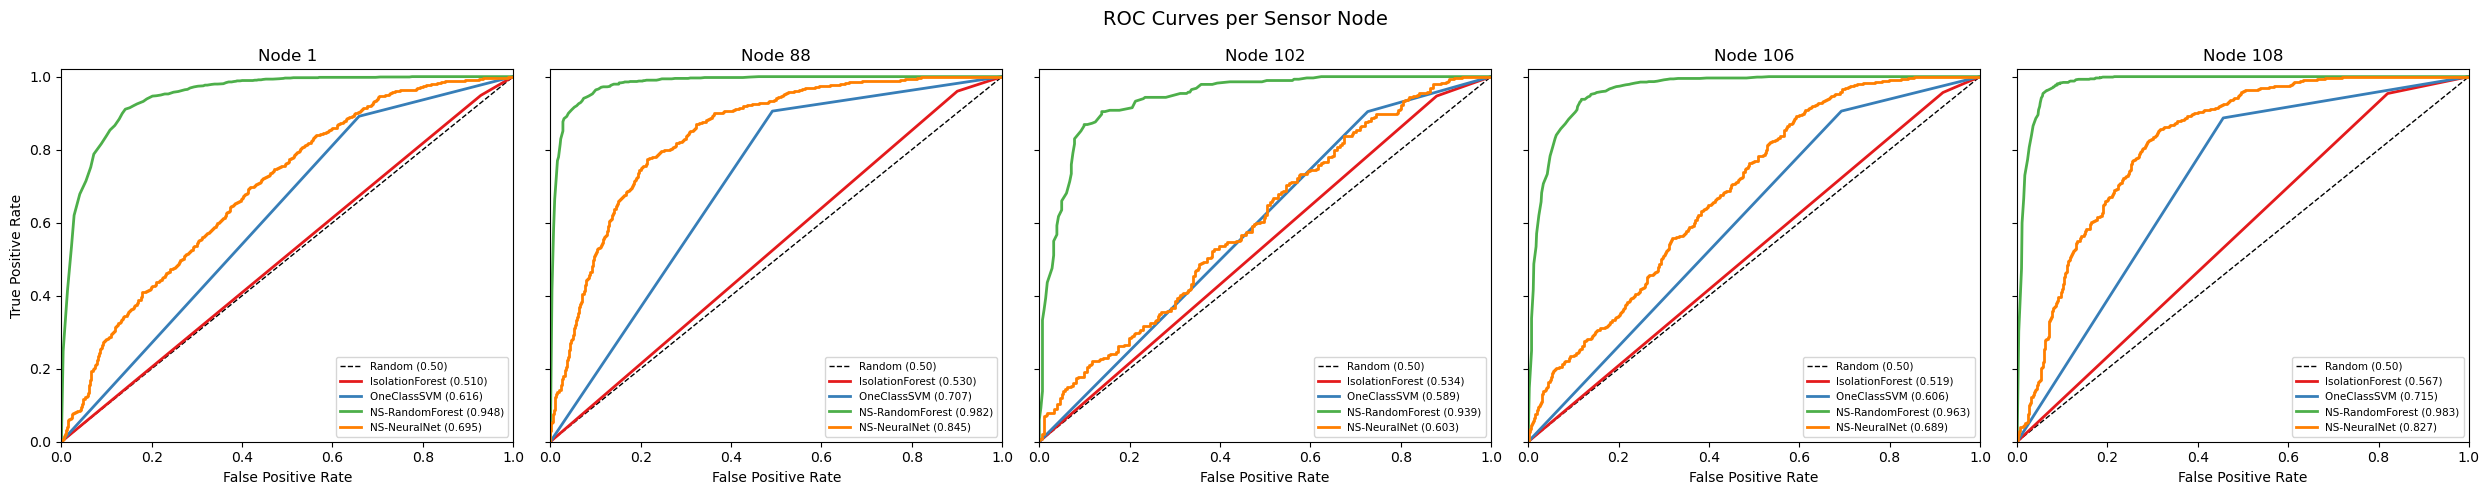

Saved output/roc_curves.png


In [40]:
detector_names  = list(next(iter(all_results.values())).keys())
node_ids_sorted = sorted(all_results.keys())
det_colors      = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']

fig, axes = plt.subplots(1, len(node_ids_sorted),
                         figsize=(5 * len(node_ids_sorted), 5),
                         sharey=True)
if len(node_ids_sorted) == 1:
    axes = [axes]

for ax, node_id in zip(axes, node_ids_sorted):
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (0.50)')
    for color, det_name in zip(det_colors, detector_names):
        res = all_results[node_id].get(det_name)
        if res is None:
            continue
        fpr, tpr, _ = roc_curve(res['y_true'], res['y_score'])
        ax.plot(fpr, tpr, color=color, lw=2, label=f"{det_name} ({res['auc']:.3f})")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.02])
    ax.set_title(f'Node {node_id}')
    ax.set_xlabel('False Positive Rate')
    ax.legend(fontsize=7.5, loc='lower right')

axes[0].set_ylabel('True Positive Rate')
fig.suptitle('ROC Curves per Sensor Node', fontsize=14)
plt.tight_layout()

roc_path = os.path.join(OUTPUT_DIR, 'roc_curves.png')
plt.savefig(roc_path, bbox_inches='tight', dpi=150)
plt.show()
print(f'Saved {roc_path}')

## 7. AUC Summary

In [41]:
rows = [
    {
        'node_id': nid,
        **{
            det: (all_results[nid][det]['auc'] if all_results[nid][det] else None)
            for det in detector_names
        },
    }
    for nid in sorted(all_results)
]
results_df = pd.DataFrame(rows).set_index('node_id')
results_df.to_csv(os.path.join(OUTPUT_DIR, 'results.csv'))
print(f"Saved results.csv")

results_df.style \
    .background_gradient(cmap='RdYlGn', axis=None, vmin=0.5, vmax=1.0) \
    .format('{:.4f}')

Saved results.csv


,IsolationForest,OneClassSVM,NS-RandomForest,NS-NeuralNet
node_id,,,,
1,0.5102,0.6163,0.9479,0.6948
88,0.5297,0.7070,0.9818,0.8451
102,0.5337,0.5887,0.9388,0.6035
106,0.5193,0.6062,0.9633,0.6892
108,0.5669,0.7153,0.9827,0.8269
